# Map-based simulation for differential pointing per frequency channel

## Here, we introduce how to assess differential pointing systematics by the map-based simulation in the case of a single frequency channel.


In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from scanfields import ScanFields, plot_maps

In [2]:
# Load single detector map
base_path = "../../crosslinks_2407_3yr"
data = ScanFields()
ch_id = 0
channel = data.all_channels[ch_id]
sf_ch = ScanFields.load_channel(base_path, channel)
print("Channel: ", channel)

Channel:  L1-040


In [3]:
# We can access LiteBIRD frequency bands name and its FWHMs
print(data.all_channels)
print(data.fwhms)

['L1-040', 'L2-050', 'L1-060', 'L3-068', 'L2-068', 'L4-078', 'L1-078', 'L3-089', 'L2-089', 'L4-100', 'L3-119', 'L4-140', 'M1-100', 'M2-119', 'M1-140', 'M2-166', 'M1-195', 'H1-195', 'H2-235', 'H1-280', 'H2-337', 'H3-402']
[70.5, 58.5, 51.1, 41.6, 47.1, 36.9, 43.8, 33.0, 41.5, 30.2, 26.3, 23.7, 37.8, 33.6, 30.8, 28.9, 28.0, 28.6, 24.7, 22.5, 20.9, 17.9]


In [4]:
# Prepare input map and transfer function
fiducial_map = hp.read_map("./cmb_0000_nside_128_seed_33.fits", field=(0,1,2)) * 1e6
fwhm = np.deg2rad(data.fwhms[ch_id]/60.)
input_map = hp.smoothing(fiducial_map, fwhm)
nside = hp.get_nside(input_map[0])
lmax = 3*nside-1
bl = hp.gauss_beam(fwhm, lmax=lmax, pol=True)

In [5]:
# Make gain value per detector
# If random is False, all detectors have the same gain value
# If random is True, gain values are randomly generated with Gaussian distribution
random = False

if random == False:
    rho = np.ones(sf_ch.ndet) * np.deg2rad(1/60.)
    chi = np.ones(sf_ch.ndet) * 0.0
else:
    sigma = np.deg2rad(1/60.)
    np.random.seed(1234)
    rho = np.random.normal(loc=0.0, scale=sigma, size=sf_ch.ndet)
    chi = np.random.normal(loc=0.0, scale=sigma, size=sf_ch.ndet)
mdim = 3
total_field = ScanFields.sim_diff_pointing_channel(base_path, channel, mdim, input_map, rho, chi)

Here, we inpose $(\rho,\chi)=(1,0)$ arcmin offset.

We can solve given lenear system by `.solve` method as bellow:


In [6]:
# This method is used when we have already  prepared the signal field detector by detector.
output_map = total_field.solve()
residual = input_map - output_map

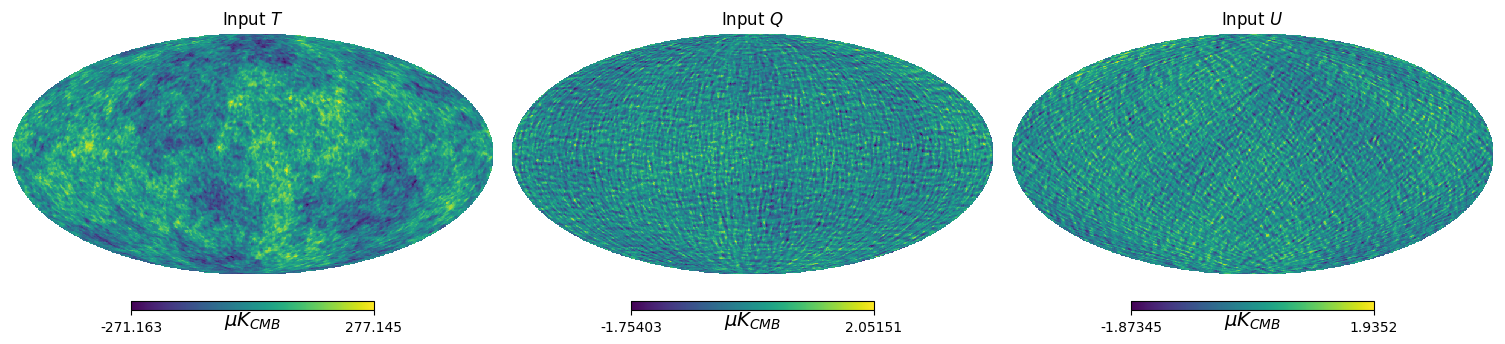

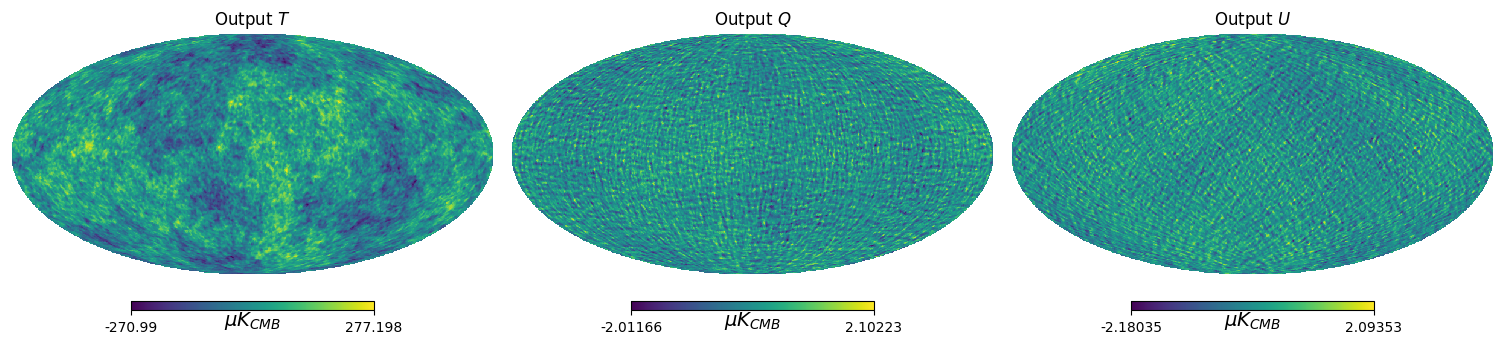

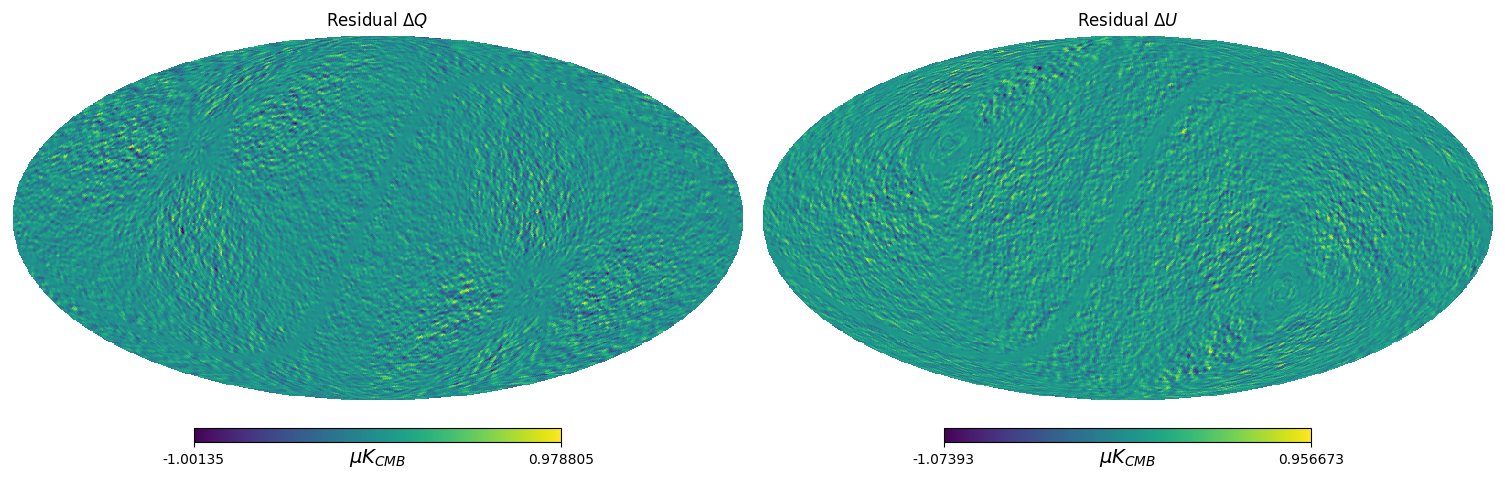

In [7]:
# Show obtained maps
plot_maps(mdim, input_map, output_map, residual)

# Let's check the power spectra

The green line shows systematics power spectrum, i.e., $\Delta C_\ell^{BB}$, which is obtained by residual map.

Althogh the green line is providing an exact solution which agrees with the binning map-making, we can perform an analitical estimation without doing the map-making.

The red line $\Delta C_{\ell, Ana}^{BB}$ is simulated by

$$
\Delta C_{\ell, Ana}^{BB} = \frac{1}{2} (\langle|{}_{1}\tilde{h}|^2\rangle + \langle|{}_{3}\tilde{h}|^2\rangle)~\rho^2~\ell^2~C_{\ell}^{TT}
$$

where $\langle|{}_{n}\tilde{h}|^2\rangle$ represents the entire sky average of the spin-n cross-link.

About the analitical discription, see [C.G.R. Wallis et al.](https://arxiv.org/abs/1604.02290).


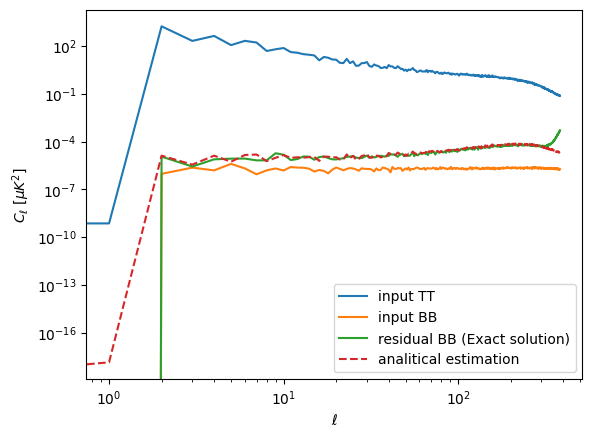

In [8]:
fiducial_cl = hp.anafast(fiducial_map)
res_cl = hp.anafast(residual)

ell = np.arange(len(fiducial_cl[0]))
xlink1_mean = np.mean(np.abs(total_field.get_xlink(1))**2)
xlink3_mean = np.mean(np.abs(total_field.get_xlink(2))**2)
ana = (1/2) * (xlink1_mean + xlink3_mean) * fiducial_cl[0] * rho[0]**2 * ell**2
#ana = (xlink1_mean + xlink3_mean) * fiducial_cl[0] * rho[0]**2 * ell**2

plt.plot(fiducial_cl[0], label="input TT")
plt.plot(fiducial_cl[2], label="input BB")
plt.plot(res_cl[2] / bl[:,2]**2, label="residual BB (Exact solution)")
plt.plot(ana, "--", label="analitical estimation")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell ~ [\mu K^2]$")
plt.xscale("log")
plt.yscale("log")
plt.legend();